In [1]:
# Importing necessary libraries
import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext
from pyspark.sql.functions import lit

appName = "Project_2"
master = "local"

# Create Configuration object for Spark.
conf = pyspark.SparkConf()\
    .set('spark.driver.host','127.0.0.1')\
    .setAppName(appName)\
    .setMaster(master)

# Create Spark Context with the new configurations rather than relying on the default one
sc = SparkContext.getOrCreate(conf=conf)

# You need to create SQL Context to conduct some database operations like what we will see later.
sqlContext = SQLContext(sc)

# If you have SQL context, you create the session from the Spark Context
spark = sqlContext.sparkSession.builder.getOrCreate()

C:\Spark\spark-3.5.0-bin-hadoop3\python\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
# Load data from csv to a dataframe on a local machine. 
# header=False means the first row is not a header 
# sep=',' means the column are seperated using ','


df_train = spark.read.csv("train70_reduced.csv",header=True, inferSchema= True)
df_test = spark.read.csv("test30_reduced.csv",header=True, inferSchema= True)
df_train = df_train.withColumn("dataset", lit("train"))
df_test = df_test.withColumn("dataset", lit("test"))
df = df_train.union(df_test)


In [3]:
db_properties={}
db_properties['username']="postgres"
db_properties['password']="Natkanvij@22"
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"

# I have kept the table name as intrusion2
db_properties['table']="MQTT" 
db_properties['driver']="org.postgresql.Driver"

df.write.format("jdbc")\
.mode("overwrite")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("Driver", db_properties['driver'])\
.save()


In [4]:
df_read = sqlContext.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()

df_read.show(1, vertical=True)
df_read.printSchema()

-RECORD 0--------------------------------
 tcp.flags                  | 0x00000018 
 tcp.time_delta             | 0.998867   
 tcp.len                    | 10         
 mqtt.conack.flags          | 0          
 mqtt.conack.flags.reserved | 0.0        
 mqtt.conack.flags.sp       | 0.0        
 mqtt.conack.val            | 0.0        
 mqtt.conflag.cleansess     | 0.0        
 mqtt.conflag.passwd        | 0.0        
 mqtt.conflag.qos           | 0.0        
 mqtt.conflag.reserved      | 0.0        
 mqtt.conflag.retain        | 0.0        
 mqtt.conflag.uname         | 0.0        
 mqtt.conflag.willflag      | 0.0        
 mqtt.conflags              | 0          
 mqtt.dupflag               | 0.0        
 mqtt.hdrflags              | 0x00000030 
 mqtt.kalive                | 0.0        
 mqtt.len                   | 8.0        
 mqtt.msg                   | 32         
 mqtt.msgid                 | 0.0        
 mqtt.msgtype               | 3.0        
 mqtt.proto_len             | 0.0 

Renaming coloumns with . to _

In [5]:
from pyspark.sql.functions import col

def replace_dot_with_underscore(data_df):
    # Replace '.' with '_' in column names
    for col_name in data_df.columns:
        new_col_name = col_name.replace('.', '_')
        data_df = data_df.withColumnRenamed(col_name, new_col_name)
    return data_df
renamed_columns_df = replace_dot_with_underscore(df_read)

In [6]:
renamed_columns_df.printSchema()

root
 |-- tcp_flags: string (nullable = true)
 |-- tcp_time_delta: double (nullable = true)
 |-- tcp_len: integer (nullable = true)
 |-- mqtt_conack_flags: string (nullable = true)
 |-- mqtt_conack_flags_reserved: double (nullable = true)
 |-- mqtt_conack_flags_sp: double (nullable = true)
 |-- mqtt_conack_val: double (nullable = true)
 |-- mqtt_conflag_cleansess: double (nullable = true)
 |-- mqtt_conflag_passwd: double (nullable = true)
 |-- mqtt_conflag_qos: double (nullable = true)
 |-- mqtt_conflag_reserved: double (nullable = true)
 |-- mqtt_conflag_retain: double (nullable = true)
 |-- mqtt_conflag_uname: double (nullable = true)
 |-- mqtt_conflag_willflag: double (nullable = true)
 |-- mqtt_conflags: string (nullable = true)
 |-- mqtt_dupflag: double (nullable = true)
 |-- mqtt_hdrflags: string (nullable = true)
 |-- mqtt_kalive: double (nullable = true)
 |-- mqtt_len: double (nullable = true)
 |-- mqtt_msg: string (nullable = true)
 |-- mqtt_msgid: double (nullable = true)
 |-

In [7]:
from pyspark.sql.functions import avg


# Filter the DataFrame to select only rows where 'dataset' is 'train'
train_df = renamed_columns_df.filter(renamed_columns_df['dataset'] == 'train')

# Calculate the average of the 'len' column for the 'train' dataset
average_length = train_df.agg(avg('mqtt_len')).collect()[0][0]

# Print the average length
print("Average length for 'train' dataset:", average_length)

Average length for 'train' dataset: 31.435725201384873


In [8]:
average_lengths = renamed_columns_df.groupBy('target').agg(avg('tcp_len').alias('average_tcp_length'))
df = renamed_columns_df
average_lengths.show()


+----------+------------------+
|    target|average_tcp_length|
+----------+------------------+
|   slowite|3.9993479678330797|
|bruteforce|3.9871043376318873|
|     flood|13313.415986949429|
| malformed| 20.97491761259612|
|       dos|312.65759830457716|
|legitimate| 7.776101001432345|
+----------+------------------+



In [9]:
from pyspark.sql.functions import dense_rank, desc
from pyspark.sql.window import Window


def get_X_most_frequent_tcp_flags(x):
    distinct_flags = df.select('tcp_flags').distinct().count()
    if x > distinct_flags:
        print(f"There are only {distinct_flags} distinct TCP flags in this dataset. Showing all {distinct_flags} TCP flags ranked with dense ranking.")
        x = distinct_flags
    window_spec = Window.partitionBy().orderBy(desc('count'))
    ranked_df = df.groupBy('tcp_flags').count().orderBy(desc('count')).withColumn("dense_rank", dense_rank().over(window_spec))
    result = ranked_df.filter(col("dense_rank") <= x)
    result.show()

In [10]:
get_X_most_frequent_tcp_flags(4)

+----------+------+----------+
| tcp_flags| count|dense_rank|
+----------+------+----------+
|0x00000018|183076|         1|
|0x00000010|134547|         2|
|0x00000011|  4198|         3|
|0x00000002|  3372|         4|
|0x00000012|  3372|         4|
+----------+------+----------+



In [11]:
from pyspark.sql.functions import when

renamed_columns_df = renamed_columns_df.withColumn("target", when(renamed_columns_df["target"] == "dos", "denial-of-service").otherwise(renamed_columns_df["target"]))
renamed_columns_df = renamed_columns_df.withColumn("target", when(renamed_columns_df["target"] == "bruteforce", "brute-force").otherwise(renamed_columns_df["target"]))



In [12]:
unique_target_types = renamed_columns_df.select('target').distinct()

# Collect the unique values and convert them to a list
unique_target_types_list = [row.target for row in unique_target_types.collect()]

# Print the unique protocol types
print("Unique Targets we have from the dataset:")
for target in unique_target_types_list:
    print(target)




Unique Targets we have from the dataset:
slowite
flood
brute-force
malformed
denial-of-service
legitimate


In [13]:
from confluent_kafka import Producer
import socket
#Initialize Your Parameters here - Keep the variable values as is for the ones you can't find on the Confluent-Kafka connection 
KAFKA_CONFIG = {
    "bootstrap.servers":"pkc-lzvrd.us-west4.gcp.confluent.cloud:9092",
    "security.protocol":"SASL_SSL",
    "sasl.mechanisms":"PLAIN",
    "sasl.username":"LKGBAJ3FAQY7XT3O",
    "sasl.password":"FdsLkF9Cec8qkthIz9EAny8whhp9dZ9Wa0/YuBQZa2JjEsF/61KnaGkkpK7VW9fk",
    "session.timeout.ms":"45000",
    "group.id":"python-group-1",
    'auto.offset.reset': 'smallest',
    'client.id': socket.gethostname()
}

# Update your topic name
topic_name = "topic_0"
producer = Producer(KAFKA_CONFIG)

In [14]:
import feedparser
import time

# We are searching for Analytics in the news
feed_url = "https://news.google.com/rss/search?q=popular+cyber+attacks"
def extract_news_feed(feed_url, runtime_minutes):
    feed = feedparser.parse(feed_url)
    articles = []
    extracted_articles = set()
    start_time = time.time()
    end_time = start_time + (runtime_minutes * 60)  # Convert minutes to seconds
    while time.time() < end_time:
        for entry in feed.entries:
            link = entry.link
            title = entry.title.encode('ascii', 'ignore').decode()
            unique_id = f'{link}-{title}'
            if unique_id in extracted_articles:
                continue
            extracted_articles.add(unique_id)
            article_data = {"title": title, "link": link}
            if article_data is not None:
                producer.produce(topic_name, key=article_data["title"], value=article_data["link"])
        producer.flush()

extract_news_feed(feed_url, runtime_minutes=5)

In [15]:
from confluent_kafka import Consumer
from pyspark.sql.types import *
import string


# Clean the punctation by making a translation table that maps punctations to empty strings
translator = str.maketrans("", "", string.punctuation.replace('-', ''))


emp_RDD = spark.sparkContext.emptyRDD()
# Defining the schema of the DataFrame
columns = StructType([StructField('key', StringType(), False),
                      StructField('value', StringType(), False)])

# Creating an empty DataFrame
df = spark.createDataFrame(data=emp_RDD,
                                   schema=columns)
 
# Printing the DataFrame with no data
df.show()

consumer = Consumer(KAFKA_CONFIG)
consumer.subscribe([topic_name])

try:
    i = 0
    while i < 5:
        msg = consumer.poll(timeout=1.0)
        if msg is None:
            i = i + 1
            print("Waiting...")
            continue
        if msg is not None:
            key = msg.key().decode('utf-8').lower().translate(translator)
            #print(key)
            cleaned_key = " ".join(key.split())
            value = msg.value().decode('utf-8')
            added_row = [[cleaned_key,value]]
            added_df = spark.createDataFrame(added_row, columns)
            df = df.union(added_df)

except KeyboardInterrupt:
    pass
finally:
    consumer.close()
    df.show()


+---+-----+
|key|value|
+---+-----+
+---+-----+

Waiting...
Waiting...
Waiting...
Waiting...
Waiting...
+---+-----+
|key|value|
+---+-----+
+---+-----+



In [16]:
from pyspark.sql.functions import *
# import nltk 
# nltk.download('stopwords')

# stop_words = nltk.corpus.stopwords.words('english')
streamed_data = df.withColumn('word', explode(split(col('key'), ' '))) \
                .filter(col('word').isin(unique_target_types_list)) \
                .groupBy('word') \
                .count() \
                .sort('count', ascending=False)
    
    
    
streamed_data.show()

+----+-----+
|word|count|
+----+-----+
+----+-----+



renaming the target values to the original type

In [83]:
from pyspark.sql.functions import when

renamed_columns_df = renamed_columns_df.withColumn("target", when(renamed_columns_df["target"] == "denial-of-service", "dos").otherwise(renamed_columns_df["target"]))
renamed_columns_df = renamed_columns_df.withColumn("target", when(renamed_columns_df["target"] == "brute-force", "bruteforce").otherwise(renamed_columns_df["target"]))



Task- III Machine Learning Modeling

Feature Engineering

*Check for Null and NA values in the coloumns*


In [84]:
from pyspark.sql.functions import *

null_df = renamed_columns_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) \
                        for c in renamed_columns_df.columns])

null_df.show(truncate=False, vertical=True)

-RECORD 0-------------------------
 tcp_flags                  | 0   
 tcp_time_delta             | 0   
 tcp_len                    | 0   
 mqtt_conack_flags          | 0   
 mqtt_conack_flags_reserved | 0   
 mqtt_conack_flags_sp       | 0   
 mqtt_conack_val            | 0   
 mqtt_conflag_cleansess     | 0   
 mqtt_conflag_passwd        | 0   
 mqtt_conflag_qos           | 0   
 mqtt_conflag_reserved      | 0   
 mqtt_conflag_retain        | 0   
 mqtt_conflag_uname         | 0   
 mqtt_conflag_willflag      | 0   
 mqtt_conflags              | 0   
 mqtt_dupflag               | 0   
 mqtt_hdrflags              | 0   
 mqtt_kalive                | 0   
 mqtt_len                   | 0   
 mqtt_msg                   | 0   
 mqtt_msgid                 | 0   
 mqtt_msgtype               | 0   
 mqtt_proto_len             | 0   
 mqtt_protoname             | 0   
 mqtt_qos                   | 0   
 mqtt_retain                | 0   
 mqtt_sub_qos               | 0   
 mqtt_suback_qos    

There are no null/NA values in the coloumns of our dataset. Thus, we do not need to do imputation for null/Na values.

*Checking duplicate rows*

In [85]:
row_count = renamed_columns_df.count()
print(f"Current number of rows:{row_count}")

df = renamed_columns_df.dropDuplicates()
row_count = df.count()
print(f"After eliminating duplicates, current number of rows:{row_count}")

Current number of rows:330936
After eliminating duplicates, current number of rows:131711


*Classifying our columns*

To classify our columns lets first check the unique values in the coloumns.

In [86]:
for column in renamed_columns_df.columns:
    unique_values = df.select(column).distinct()
    print(f"Column: {column}")
    unique_values.show(truncate=False)
    print("\n")


Column: tcp_flags
+----------+
|tcp_flags |
+----------+
|0x00000004|
|0x00000010|
|0x00000019|
|0x00000002|
|0x00000012|
|0x00000014|
|0x00000018|
|0x00000011|
+----------+



Column: tcp_time_delta
+--------------+
|tcp_time_delta|
+--------------+
|0.00457       |
|8.77E-4       |
|0.999942      |
|1.000047      |
|0.00195       |
|1.00005       |
|7.18E-4       |
|7.5E-4        |
|0.003369      |
|0.498969      |
|0.001045      |
|1.001015      |
|0.498877      |
|0.003699      |
|3.71E-4       |
|0.049345      |
|0.001243      |
|0.003333      |
|0.018394      |
|0.500367      |
+--------------+
only showing top 20 rows



Column: tcp_len
+-------+
|tcp_len|
+-------+
|148    |
|496    |
|1342   |
|833    |
|1460   |
|858    |
|1025   |
|540    |
|1395   |
|392    |
|31     |
|516    |
|1352   |
|85     |
|580    |
|137    |
|65     |
|883    |
|879    |
|1223   |
+-------+
only showing top 20 rows



Column: mqtt_conack_flags
+-----------------+
|mqtt_conack_flags|
+-------------

+----------+
|mqtt_msgid|
+----------+
|6653.0    |
|2815.0    |
|692.0     |
|6454.0    |
|7554.0    |
|934.0     |
|4142.0    |
|1761.0    |
|7115.0    |
|3597.0    |
|5983.0    |
|305.0     |
|7782.0    |
|5858.0    |
|8649.0    |
|2734.0    |
|299.0     |
|2862.0    |
|3980.0    |
|6433.0    |
+----------+
only showing top 20 rows



Column: mqtt_msgtype
+------------+
|mqtt_msgtype|
+------------+
|8.0         |
|0.0         |
|1.0         |
|4.0         |
|14.0        |
|3.0         |
|2.0         |
|13.0        |
|5.0         |
|9.0         |
|12.0        |
+------------+



Column: mqtt_proto_len
+--------------+
|mqtt_proto_len|
+--------------+
|0.0           |
|4.0           |
+--------------+



Column: mqtt_protoname
+--------------+
|mqtt_protoname|
+--------------+
|MQTT          |
|0             |
+--------------+



Column: mqtt_qos
+--------+
|mqtt_qos|
+--------+
|0.0     |
|1.0     |
+--------+



Column: mqtt_retain
+-----------+
|mqtt_retain|
+-----------+
|0.0   

We can see that there are coloumns with only one unique value. Let's drop these coloumns.

In [87]:
df = df.drop("mqtt_conack_flags_reserved","mqtt_conack_flags_sp","mqtt_conflag_qos","mqtt_conflag_reserved",
             "mqtt_conflag_retain","mqtt_conflag_willflag","mqtt_sub_qos","mqtt_suback_qos","mqtt_willmsg",
             "mqtt_willmsg_len","mqtt_willtopic","mqtt_willtopic_len")
df.printSchema()

root
 |-- tcp_flags: string (nullable = true)
 |-- tcp_time_delta: double (nullable = true)
 |-- tcp_len: integer (nullable = true)
 |-- mqtt_conack_flags: string (nullable = true)
 |-- mqtt_conack_val: double (nullable = true)
 |-- mqtt_conflag_cleansess: double (nullable = true)
 |-- mqtt_conflag_passwd: double (nullable = true)
 |-- mqtt_conflag_uname: double (nullable = true)
 |-- mqtt_conflags: string (nullable = true)
 |-- mqtt_dupflag: double (nullable = true)
 |-- mqtt_hdrflags: string (nullable = true)
 |-- mqtt_kalive: double (nullable = true)
 |-- mqtt_len: double (nullable = true)
 |-- mqtt_msg: string (nullable = true)
 |-- mqtt_msgid: double (nullable = true)
 |-- mqtt_msgtype: double (nullable = true)
 |-- mqtt_proto_len: double (nullable = true)
 |-- mqtt_protoname: string (nullable = true)
 |-- mqtt_qos: double (nullable = true)
 |-- mqtt_retain: double (nullable = true)
 |-- mqtt_ver: double (nullable = true)
 |-- target: string (nullable = true)
 |-- dataset: string 

Now, there are binary coloumns which has values as strings, values other than 0 and 1. Therefore, lets encode these coloumns with binary values 0 and 1. Also we will cast these coloumns to datatype double.

In [88]:
from pyspark.sql.functions import col, when

# Note when a coloumn is encoded we will drop the original coloumn.
conversion_map1 = {"0": 0, "0x00000000": 1}
conversion_map2 = {"train": 0, "test": 1}
conversion_map3 = {"0.0": 0, "5.0": 1}
conversion_map4 = {"0.0": 0, "4.0": 1}
conversion_map5 = {"MQTT": 0, "0": 1}

# Note in the below code "mqtt_conack_flags"] == "0" and df["dataset"] == "train" is used as its dataype is a string
df_binary = df.withColumn("mqtt_conack_flags_encoded_binary", when(df["mqtt_conack_flags"] == "0", conversion_map1["0"]).otherwise(conversion_map1["0x00000000"])).drop('mqtt_conack_flags')
df_binary = df_binary.withColumn("dataset_encoded_binary", when(df["dataset"] == "train", conversion_map2["train"]).otherwise(conversion_map2["test"])).drop('dataset')

# Note in the below code df["mqtt_conack_val"] == 0.0 and df["mqtt_proto_len"] == 0.0 is used as its dataype is a double
df_binary = df_binary.withColumn("mqtt_conack_val_encoded_binary", when(df["mqtt_conack_val"] == 0.0, conversion_map3["0.0"]).otherwise(conversion_map3["5.0"])).drop('mqtt_conack_val')
df_binary = df_binary.withColumn("mqtt_proto_len_encoded_binary", when(df["mqtt_proto_len"] == 0.0, conversion_map4["0.0"]).otherwise(conversion_map4["4.0"])).drop('mqtt_proto_len')

# Note in the below code ["mqtt_protoname"] == MQTT is used as its dataype is a string
df_binary = df_binary.withColumn("mqtt_protoname_encoded_binary", when(df["mqtt_protoname"] == 'MQTT', conversion_map5["MQTT"]).otherwise(conversion_map5["0"])).drop('mqtt_protoname')

# Casting string datatypes
df_binary = df_binary.withColumn('mqtt_conack_flags_encoded_binary', col('mqtt_conack_flags_encoded_binary').cast('double'))
df_binary = df_binary.withColumn('dataset_encoded_binary', col('dataset_encoded_binary').cast('double'))
df_binary = df_binary.withColumn('mqtt_protoname_encoded_binary', col('mqtt_protoname_encoded_binary').cast('double'))


df_binary.printSchema()
df = df_binary


root
 |-- tcp_flags: string (nullable = true)
 |-- tcp_time_delta: double (nullable = true)
 |-- tcp_len: integer (nullable = true)
 |-- mqtt_conflag_cleansess: double (nullable = true)
 |-- mqtt_conflag_passwd: double (nullable = true)
 |-- mqtt_conflag_uname: double (nullable = true)
 |-- mqtt_conflags: string (nullable = true)
 |-- mqtt_dupflag: double (nullable = true)
 |-- mqtt_hdrflags: string (nullable = true)
 |-- mqtt_kalive: double (nullable = true)
 |-- mqtt_len: double (nullable = true)
 |-- mqtt_msg: string (nullable = true)
 |-- mqtt_msgid: double (nullable = true)
 |-- mqtt_msgtype: double (nullable = true)
 |-- mqtt_qos: double (nullable = true)
 |-- mqtt_retain: double (nullable = true)
 |-- mqtt_ver: double (nullable = true)
 |-- target: string (nullable = true)
 |-- mqtt_conack_flags_encoded_binary: double (nullable = false)
 |-- dataset_encoded_binary: double (nullable = false)
 |-- mqtt_conack_val_encoded_binary: integer (nullable = false)
 |-- mqtt_proto_len_encod

Lets investigate more on the coloumn mqtt_msg

In [89]:
unique_values_count = df.select(countDistinct(col('mqtt_msg')).alias('unique_values_count')).collect()[0]['unique_values_count']

print(f"Number of unique values in 'your_column': {unique_values_count}")

Number of unique values in 'your_column': 50055


As we can see this coloumn has roughly half unique values with very large individual dataset numeric value, this coloumn will cause the pipeline to fail. hence dropping this coloumn. 

In [90]:
df = df.drop("mqtt_msg")
df.printSchema()

num_columns = len(df.columns)

# Print the number of columns
print("Number of columns:", num_columns)

root
 |-- tcp_flags: string (nullable = true)
 |-- tcp_time_delta: double (nullable = true)
 |-- tcp_len: integer (nullable = true)
 |-- mqtt_conflag_cleansess: double (nullable = true)
 |-- mqtt_conflag_passwd: double (nullable = true)
 |-- mqtt_conflag_uname: double (nullable = true)
 |-- mqtt_conflags: string (nullable = true)
 |-- mqtt_dupflag: double (nullable = true)
 |-- mqtt_hdrflags: string (nullable = true)
 |-- mqtt_kalive: double (nullable = true)
 |-- mqtt_len: double (nullable = true)
 |-- mqtt_msgid: double (nullable = true)
 |-- mqtt_msgtype: double (nullable = true)
 |-- mqtt_qos: double (nullable = true)
 |-- mqtt_retain: double (nullable = true)
 |-- mqtt_ver: double (nullable = true)
 |-- target: string (nullable = true)
 |-- mqtt_conack_flags_encoded_binary: double (nullable = false)
 |-- dataset_encoded_binary: double (nullable = false)
 |-- mqtt_conack_val_encoded_binary: integer (nullable = false)
 |-- mqtt_proto_len_encoded_binary: integer (nullable = false)
 |

Now, lets classify our variables

In [91]:
nominal_cols = ['tcp_flags','mqtt_conflags','mqtt_hdrflags']
continuous_cols = ['tcp_time_delta','tcp_len','mqtt_len','mqtt_msgid','mqtt_kalive','mqtt_msgtype' ]
binary_cols = ['mqtt_protoname_encoded_binary','mqtt_proto_len_encoded_binary','mqtt_conack_val_encoded_binary','dataset_encoded_binary','mqtt_conack_flags_encoded_binary','mqtt_conflag_cleansess','mqtt_conflag_passwd','mqtt_conflag_uname','mqtt_dupflag', 'mqtt_qos','mqtt_retain','mqtt_ver']

Summary table for our dataset

In [92]:
df.summary().show(truncate=False, vertical=True)

-RECORD 0------------------------------------------------
 summary                          | count                
 tcp_flags                        | 131711               
 tcp_time_delta                   | 131711               
 tcp_len                          | 131711               
 mqtt_conflag_cleansess           | 131711               
 mqtt_conflag_passwd              | 131711               
 mqtt_conflag_uname               | 131711               
 mqtt_conflags                    | 131711               
 mqtt_dupflag                     | 131711               
 mqtt_hdrflags                    | 131711               
 mqtt_kalive                      | 131711               
 mqtt_len                         | 131711               
 mqtt_msgid                       | 131711               
 mqtt_msgtype                     | 131711               
 mqtt_qos                         | 131711               
 mqtt_retain                      | 131711               
 mqtt_ver     

Boxplots

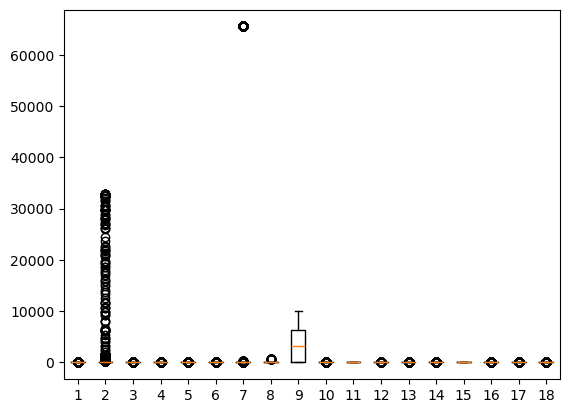

In [93]:
numeric_features = [feature[0] for feature in df.dtypes if feature[1] in ('int','double')]

import matplotlib.pyplot as plt

#Extract data and convert them into Pandas for visualization
converted_data = df[numeric_features].toPandas()

figure = plt.boxplot(converted_data)


Lets see outliers and check if we need to handle them.

In [94]:
from functools import reduce

def column_add(a,b):
     return  a.__add__(b)
    
def find_outliers(df):
    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]
    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers',reduce(column_add, ( df[col] for col in  selected_columns)))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

df_with_outlier_handling = find_outliers(df)
df_with_outlier_handling.show(1, vertical=True)

df_with_outlier_handling.groupby("total_outliers").count().show()

-RECORD 0--------------------------------------
 tcp_flags                        | 0x00000018 
 tcp_time_delta                   | 1.76E-4    
 tcp_len                          | 10         
 mqtt_conflag_cleansess           | 0.0        
 mqtt_conflag_passwd              | 0.0        
 mqtt_conflag_uname               | 0.0        
 mqtt_conflags                    | 0          
 mqtt_dupflag                     | 0.0        
 mqtt_hdrflags                    | 0x00000030 
 mqtt_kalive                      | 0.0        
 mqtt_len                         | 8.0        
 mqtt_msgid                       | 0.0        
 mqtt_msgtype                     | 3.0        
 mqtt_qos                         | 0.0        
 mqtt_retain                      | 0.0        
 mqtt_ver                         | 0.0        
 target                           | legitimate 
 mqtt_conack_flags_encoded_binary | 0.0        
 dataset_encoded_binary           | 0.0        
 mqtt_conack_val_encoded_binary   | 0   

*As there are no rows with more than 3 outliers, we will not drop any rows on the basis of outliers.*

Correlation Matrix

In [95]:
numeric_columns = [col for col, dtype in df.dtypes if dtype in ['double', 'int']]
numeric_df = df.select(numeric_columns)

# Calculate the correlation matrix
correlation_matrix = numeric_df.toPandas().corr()

# Print the correlation matrix
print(correlation_matrix)

                                  tcp_time_delta   tcp_len  \
tcp_time_delta                          1.000000 -0.015399   
tcp_len                                -0.015399  1.000000   
mqtt_conflag_cleansess                 -0.013268 -0.031589   
mqtt_conflag_passwd                    -0.008618 -0.020574   
mqtt_conflag_uname                     -0.008636 -0.020617   
mqtt_dupflag                           -0.034507  0.109376   
mqtt_kalive                            -0.006864 -0.017614   
mqtt_len                               -0.078447  0.207645   
mqtt_msgid                             -0.103342  0.062935   
mqtt_msgtype                            0.423612 -0.015667   
mqtt_qos                               -0.076878  0.203916   
mqtt_retain                            -0.002978  0.004270   
mqtt_ver                               -0.013268 -0.031589   
mqtt_conack_flags_encoded_binary       -0.012750 -0.032778   
dataset_encoded_binary                  0.002419 -0.005156   
mqtt_con

List of correlated columns that needs to be removed.

In [96]:
correlated_col = ['mqtt_proto_len_encoded_binary', 'mqtt_protoname_encoded_binary','mqtt_conflag_uname','mqtt_qos','mqtt_len','mqtt_ver']

Now, let's handle further feature engineering steps including removing correlated columns, one hot encoding, vectorizing the features and outcomes in our pipeline transformer setup.

In [97]:
from pyspark.sql.functions import col, when
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler

from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np


normal = ['normal']
slowite = ['slowite']
brute_force = ['bruteforce']
flood = ['flood']
malformed = ['malformed']
dos = ['dos']
legitimate = ['legitimate']

class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
#         label_to_binary = udf(lambda name: 0.0 if name == 'normal' else 1.0 if namdose in slowite else 2.0 if name in brute_force else 3.0 if name in flood else 4.0 if name in malformed else 5.0 if name in denial_of_service else 6.0 if name in legitimate else 7.0)  # Unknown category or any other category not listed
#         output_df = dataset.withColumn('outcome', label_to_binary(col('dataset'))).drop("dataset")  
#         output_df = output_df.withColumn('outcome', col('outcome').cast(DoubleType()))
        label_to_binary = udf(lambda name: 0.0 if name == 'normal' else 1.0 if name == 'slowite' else 2.0 if name == 'bruteforce' else 3.0 if name == 'flood' else 4.0 if name == 'malformed' else 5.0 if name == 'dos' else 6.0 if name == 'legitimate' else -1.0)  # Unknown category or any other category not listed
        output_df = dataset.withColumn('outcome', label_to_binary(col('target'))).drop("target")
        output_df = output_df.withColumn('outcome', col('outcome').cast(DoubleType()))
#         output_df = output_df.drop('dataset')
#         output_df = output_df.drop('mqtt_msg')
        return output_df

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))

        return output_df
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df

def get_preprocess_pipeline():
    # Stage where columns are casted as appropriate types
#     columns_to_impute = ["tcp_time_delta","tcp_len","mqtt_conack_val","mqtt_conflag_cleansess","mqtt_conflag_passwd","mqtt_conflag_uname","mqtt_dupflag","mqtt_kalive","mqtt_len","mqtt_msgid","mqtt_msgtype","mqtt_proto_len","mqtt_qos","mqtt_retain","mqtt_ver"]
#     imputer1 = Imputer(strategy="median", inputCols=columns_to_impute, outputCols=columns_to_impute)
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols+binary_cols+nominal_onehot_cols
    corelated_cols_to_remove = correlated_col
    for col_name in corelated_cols_to_remove:
        feature_cols.remove(col_name)
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features", handleInvalid="keep")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')

    # Stage for creating the outcome column representing whether there is attack 
    stage_outcome = OutcomeCreater()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
        nominal_onehot_cols+ binary_cols + continuous_cols + ['vectorized_features'])
    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,
        stage_vector_assembler,stage_scaler,stage_outcome,stage_column_dropper])
    return pipeline 

In [98]:
from pyspark.sql.functions import col, when
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("SystemsToolChains") \
    .getOrCreate()

Load the training and test dataframe using the pipeline

In [99]:
column_names = df.columns
split_column = 'dataset_encoded_binary'

train_set = df.filter(col(split_column) == '0').toDF(*column_names)
test_set = df.filter(col(split_column) == '1').toDF(*column_names)


Creating a preprocess pipeline for train and test dataset

In [100]:
preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(train_set)

In [101]:
pipeline_df = preprocess_pipeline_model.transform(train_set)
pipeline_df_test = preprocess_pipeline_model.transform(test_set)

In [102]:
pipeline_df.printSchema()
pipeline_df.show()

root
 |-- features: vector (nullable = true)
 |-- outcome: double (nullable = true)

+--------------------+-------+
|            features|outcome|
+--------------------+-------+
|(35,[0,1,4,12,19,...|    6.0|
|(35,[0,1,4,12,19,...|    6.0|
|(35,[0,1,4,12,19,...|    6.0|
|(35,[0,1,2,4,12,1...|    5.0|
|(35,[0,1,4,12,19,...|    6.0|
|(35,[0,1,4,12,19,...|    6.0|
|(35,[0,1,2,4,12,1...|    5.0|
|(35,[0,1,4,12,19,...|    6.0|
|(35,[0,1,4,12,19,...|    6.0|
|(35,[0,1,2,4,13,1...|    5.0|
|(35,[0,15,19,26],...|    2.0|
|(35,[0,1,2,4,13,1...|    5.0|
|(35,[0,1,2,4,12,1...|    5.0|
|(35,[0,1,2,4,12,1...|    5.0|
|(35,[0,1,2,4,13,1...|    5.0|
|(35,[0,1,4,12,19,...|    6.0|
|(35,[0,1,2,4,12,1...|    5.0|
|(35,[0,17,19,26],...|    4.0|
|(35,[0,14,19,26],...|    1.0|
|(35,[0,1,2,4,10,1...|    5.0|
+--------------------+-------+
only showing top 20 rows



Using logistic regression as the first classification model.

First we are fitting the model

In [103]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'outcome')

lrModel = lr.fit(pipeline_df) # fit the logistic regression model to the training dataset


Creating predicitions based on the anove model

In [104]:
predictions = lrModel.transform(pipeline_df_test)

In [105]:
predictions.printSchema()

root
 |-- features: vector (nullable = true)
 |-- outcome: double (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [106]:
predictions.select("rawPrediction","probability","prediction","outcome").toPandas().head()

,rawPrediction,probability,prediction,outcome
0,"[-7.166962076912546, -5.876349327388862, -6.85...","[1.948719047270581e-10, 7.083619510801849e-10,...",6.0,6.0
1,"[-7.1669699484134854, -5.876685471368786, -6.8...","[1.9224227451524251e-10, 6.985738502666139e-10...",6.0,6.0
2,"[-7.166962077304591, -5.876349321946417, -6.85...","[1.9487213658971553e-10, 7.083627980369471e-10...",6.0,6.0
3,"[-7.085424530771235, 1.0331324243656574, -1.69...","[2.8019457520356055e-13, 9.40381787224079e-10,...",5.0,5.0
4,"[-7.0935586092558625, 0.5526896732776247, -2.1...","[1.6541730296138745e-12, 3.4618191178327303e-0...",5.0,5.0


Test and Train accuracy

In [107]:
predictions_train = lrModel.transform(pipeline_df)# predictions using the training dataset
accuracy_train = (predictions_train.filter(predictions_train.outcome == predictions_train.prediction)
    .count() / float(predictions_train.count()))

accuracy_test = (predictions.filter(predictions.outcome == predictions.prediction)
    .count() / float(predictions.count()))
print(f"Train Accuracy : {np.round(accuracy_train*100,2)}%")
print(f"Test Accuracy : {np.round(accuracy_test*100,2)}%")



Train Accuracy : 95.67%
Test Accuracy : 95.38%


Confusion Matrix

In [108]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[    0     0     0     0     0     0     0]
 [    0   653   342     0   187     0     0]
 [    0     1  1933     0    13     2    48]
 [    0     0    15    84     3     0     1]
 [    0     1   763     0   833    12   218]
 [    0     0   265     0     0 27397     0]
 [    0     1    85     0     0     0  9464]]


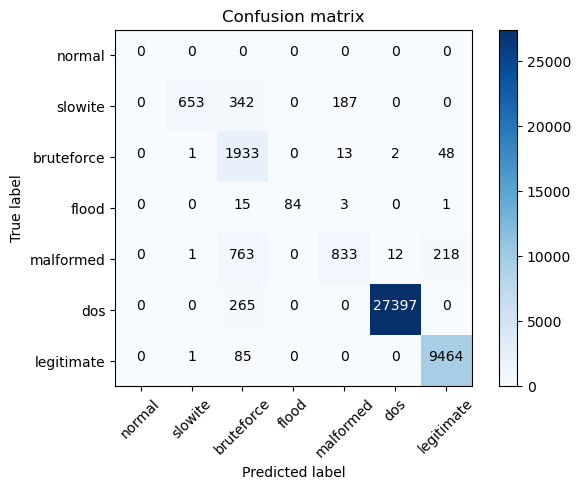

In [109]:
class_names=[0.0,1.0,2.0,3.0,4.0,5.0,6.0]
class_names_str=["normal","slowite", "bruteforce", "flood", "malformed","dos","legitimate"]

outcome_true = predictions.select("outcome")
outcome_true = outcome_true.toPandas()

pred = predictions.select("prediction")
pred = pred.toPandas()

cnf_matrix = confusion_matrix(outcome_true, pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names_str,
                      title='Confusion matrix')
plt.show()

AUC

In [110]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='outcome', metricName='f1')
print("Area under the curve/Accuracy is: ", evaluator.evaluate(predictions))

Area under the curve/Accuracy is:  0.9527723859696371


Cross-validation

In [111]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

lr = LogisticRegression(featuresCol = 'features', labelCol = 'outcome')

# Create ParamGrid for Cross Validation
lr_paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.0001, 0.001, 0.1])
             .addGrid(lr.maxIter, [10, 100, 1000])
             .build())

evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='outcome', metricName='f1')

# Create a CrossValidator for multi-class classification
lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=lr_paramGrid, evaluator=evaluator, numFolds=5)

# Fit the CrossValidator to your data
cv_model = lr_cv.fit(pipeline_df)

# Make predictions on your test data
predictions = cv_model.transform(pipeline_df_test)

# Evaluate the model's performance using the F1 score or other relevant metrics
f1_score = evaluator.evaluate(predictions)

print(predictions)

DataFrame[features: vector, outcome: double, rawPrediction: vector, probability: vector, prediction: double]


In [112]:
print(f"Area under the curve/Accuracy is: {f1_score}")


Area under the curve/Accuracy is: 0.9519496559358951


Random Forrest Classifier is our second classification model

In [113]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'outcome')
rf_model = rf.fit(pipeline_df)

In [114]:
predictions = rf_model.transform(pipeline_df_test)

In [115]:
predictions.printSchema()

root
 |-- features: vector (nullable = true)
 |-- outcome: double (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [116]:
predictions.select("rawPrediction","probability","prediction","outcome").toPandas().head()

,rawPrediction,probability,prediction,outcome
0,"[0.0, 0.07907099106069214, 0.14001049396305537...","[0.0, 0.0039535495530346075, 0.007000524698152...",6.0,6.0
1,"[0.0, 0.07907099106069214, 0.14001049396305537...","[0.0, 0.0039535495530346075, 0.007000524698152...",6.0,6.0
2,"[0.0, 0.07907099106069214, 0.14001049396305537...","[0.0, 0.0039535495530346075, 0.007000524698152...",6.0,6.0
3,"[0.0, 0.01987669758920522, 0.01685229883386163...","[0.0, 0.000993834879460261, 0.0008426149416930...",5.0,5.0
4,"[0.0, 0.01987669758920522, 0.01685229883386163...","[0.0, 0.000993834879460261, 0.0008426149416930...",5.0,5.0


Test and Train accuracy

In [117]:
rf_prediction_train = rf_model.transform(pipeline_df)
rf_prediction_test = rf_model.transform(pipeline_df_test)

rf_accuracy_train = (rf_prediction_train.filter(rf_prediction_train.outcome == rf_prediction_train.prediction)
    .count()/ float(rf_prediction_train.count()))
rf_accuracy_test = (rf_prediction_test.filter(rf_prediction_test.outcome == rf_prediction_test.prediction)
    .count() / float(rf_prediction_test.count()))

rf_auc = evaluator.evaluate(rf_prediction_test)

print(f"Train accuracy = {np.round(rf_accuracy_train*100,2)}%, test accuracy = {np.round(rf_accuracy_test*100,2)}%")

Train accuracy = 94.59%, test accuracy = 94.09%


Confusion Matrix

In [118]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[    0     0     0     0     0     0     0]
 [    0   652   523     0     7     0     0]
 [    0     0  1896     0    45     0    56]
 [    0     0    14     0     1     0    88]
 [    0     0   959     0   424    24   420]
 [    0     0   265     0     0 27384    13]
 [    0     1    44     0    41     0  9464]]


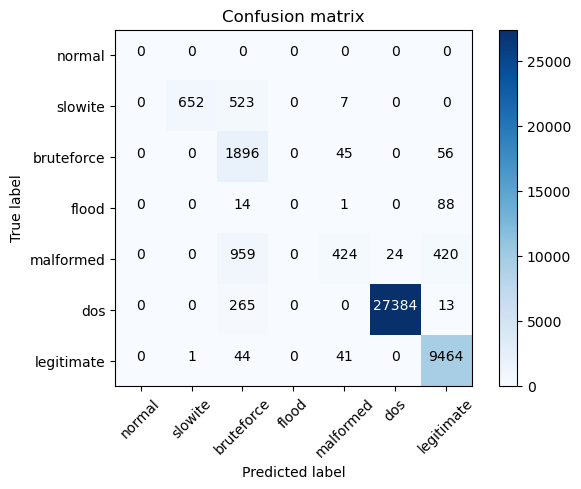

In [119]:
class_names=[0.0,1.0,2.0,3.0,4.0,5.0,6.0]
class_names_str=["normal","slowite", "bruteforce", "flood", "malformed","dos","legitimate"]

outcome_true = predictions.select("outcome")
outcome_true = outcome_true.toPandas()

pred = predictions.select("prediction")
pred = pred.toPandas()

cnf_matrix = confusion_matrix(outcome_true, pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names_str,
                      title='Confusion matrix')
plt.show()

Cross validation

In [120]:
rf_paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [5, 10, 15])# maximum depth for each tree
             .addGrid(rf.numTrees,[10, 20, 40])# number of trues
             .build())

rf_cv = CrossValidator(estimator=rf, estimatorParamMaps=rf_paramGrid, 
                    evaluator=evaluator, numFolds=5)

rf_cv_model = rf_cv.fit(pipeline_df)

rf_cv_prediction_test = rf_cv_model.transform(pipeline_df_test)
rf_cv_auc = evaluator.evaluate(rf_cv_prediction_test)

In [121]:
print(f"Before cross-validation and parameter tuning, AUC/accuracy={np.round(rf_auc,2)}")
print(f"After cross-validation and parameter tuning, AUC/accuracy={np.round(rf_cv_auc,2)}")

Before cross-validation and parameter tuning, AUC/accuracy=0.93
After cross-validation and parameter tuning, AUC/accuracy=0.95


Pytorch ML modelling

Creating the pipeline and splitting our dataset to validation_data and test_data

In [122]:
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import Imputer, StandardScaler, StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np
import pandas as pd
import torch 
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Convert Spark DataFrames to Pandas DataFrames
nslkdd_pd = pipeline_df.toPandas()
nslkdd_test_pd = pipeline_df_test.toPandas()

# Split the data into training, validation, and testing sets
# 50% of KDDTest+ for validation and the remaining 50% for testing
split_ratio = 0.5
split_index = int(len(nslkdd_test_pd) * split_ratio)

validation_data = nslkdd_test_pd[:split_index]
test_data = nslkdd_test_pd[split_index:]

Creating tensors of train, test and validate datasets.

In [123]:
x_train = torch.from_numpy(np.array(nslkdd_pd['features'].values.tolist(),np.float32))
y_train = torch.from_numpy(np.array(nslkdd_pd['outcome'].values.tolist(),np.int64))
x_validate = torch.from_numpy(np.array(validation_data['features'].values.tolist(),np.float32))
y_validate = torch.from_numpy(np.array(validation_data['outcome'].values.tolist(),np.int64))
x_test = torch.from_numpy(np.array(test_data['features'].values.tolist(),np.float32))
y_test = torch.from_numpy(np.array(test_data['outcome'].values.tolist(),np.int64))

In [124]:
print(x_train.shape)


torch.Size([89390, 35])


In [125]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

class MyDataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self,idx):
        return (self.x[idx],self.y[idx])

train_dataset = MyDataset(x_train,y_train)
validate_dataset = MyDataset(x_validate,y_validate)
test_dataset = MyDataset(x_test,y_test)

Deep Neural Network

Neural Network framework

In [126]:
import torch.nn as nn

class myMultilayerPerceptron(nn.Module):
    def __init__(self,input_dm,output_dm):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(input_dm,60),
            nn.Tanh(),
            nn.Linear(60,30),
            nn.Tanh(),
            nn.Linear(30,15),
            nn.Tanh(),
            nn.Linear(15,7),
            nn.Tanh(),
            nn.Linear(7,output_dm)
        )
    def forward(self,x):
        y = self.sequential(x)
        return y

Initializing instance of our model

In [127]:
mymodel = myMultilayerPerceptron(x_train.shape[1],7)
print(mymodel)

myMultilayerPerceptron(
  (sequential): Sequential(
    (0): Linear(in_features=35, out_features=60, bias=True)
    (1): Tanh()
    (2): Linear(in_features=60, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=15, bias=True)
    (5): Tanh()
    (6): Linear(in_features=15, out_features=7, bias=True)
    (7): Tanh()
    (8): Linear(in_features=7, out_features=7, bias=True)
  )
)


In [128]:
# hyperparameters
lr = 0.1 
batch_size = 64
N_epochs = 10

loss_fun = nn.CrossEntropyLoss()

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
validate_dataloader = DataLoader(validate_dataset, batch_size = batch_size, shuffle = True)

# Adam Optimizer
optimizer = torch.optim.Adam(mymodel.parameters(),lr = lr)

losses = []
accuracies = []

validate_losses = []
validate_accuracies = []

current_best_accuracy = 0.0

import numpy as np
for epoch in range(N_epochs):
    
    batch_loss = []
    batch_accuracy = []
    
    for x_batch,y_batch in train_dataloader:
        prediction_score = mymodel(x_batch)
        loss = loss_fun(prediction_score,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.detach().numpy())
        prediction_label = torch.argmax(prediction_score.detach(),dim=1).numpy()
        batch_accuracy.append(np.sum(prediction_label == y_batch.numpy())/x_batch.shape[0])
    
    validate_batch_loss = []
    validate_batch_accuracy = []
    
    for x_batch,y_batch in validate_dataloader:
        prediction_score = mymodel(x_batch)
        loss = loss_fun(prediction_score,y_batch)
        validate_batch_loss.append(loss.detach())
        prediction_label = torch.argmax(prediction_score.detach(),dim=1).numpy()
        validate_batch_accuracy.append(np.sum(prediction_label == y_batch.numpy())/x_batch.shape[0])
    
    losses.append(np.mean(np.array(batch_loss)))
    validate_losses.append(np.mean(np.array(validate_batch_loss)))
    
    accuracies.append(np.mean(np.array(batch_accuracy)))
    validate_accuracies.append(np.mean(np.array(validate_batch_accuracy)))
    
    print(f"Epoch={epoch},train_loss={losses[-1]},validate_loss={validate_losses[-1]}")
    print(f"Train_accuracy={np.round(accuracies[-1]*100,2)}%,validate_accuracy={np.round(validate_accuracies[-1]*100,2)}%")
    
    
    
    
    if validate_accuracies[-1]>current_best_accuracy:
        print("Current epoch is best so far, saving model...")
        torch.save(mymodel.state_dict(),'current_best_model')
        current_best_accuracy = validate_accuracies[-1]

Epoch=0,train_loss=0.22676397860050201,validate_loss=0.20003299415111542
Train_accuracy=92.13%,validate_accuracy=91.92%
Current epoch is best so far, saving model...
Epoch=1,train_loss=0.19447417557239532,validate_loss=0.23981551826000214
Train_accuracy=93.02%,validate_accuracy=92.98%
Current epoch is best so far, saving model...
Epoch=2,train_loss=0.20002785325050354,validate_loss=0.22096838057041168
Train_accuracy=93.12%,validate_accuracy=92.01%
Epoch=3,train_loss=0.2021917849779129,validate_loss=0.233767569065094
Train_accuracy=93.1%,validate_accuracy=92.98%
Current epoch is best so far, saving model...
Epoch=4,train_loss=0.21347017586231232,validate_loss=0.3639950454235077
Train_accuracy=92.81%,validate_accuracy=89.56%
Epoch=5,train_loss=0.7952061891555786,validate_loss=0.922766923904419
Train_accuracy=75.66%,validate_accuracy=67.6%
Epoch=6,train_loss=0.8437505960464478,validate_loss=0.9514089226722717
Train_accuracy=73.72%,validate_accuracy=67.58%
Epoch=7,train_loss=0.845016419887

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

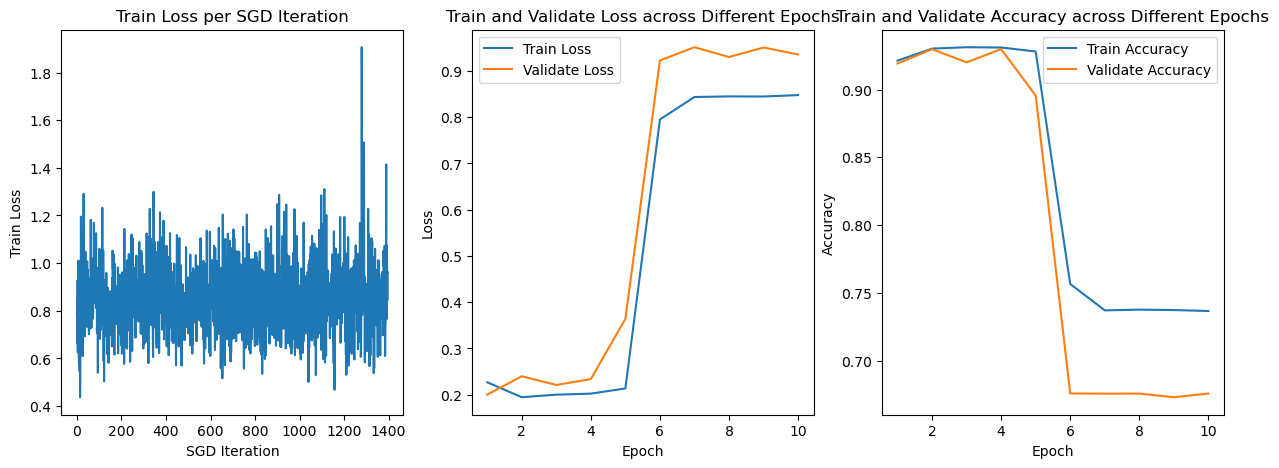

In [129]:
import matplotlib.pyplot as plt
import numpy as np

# Reshape losses and accuracies arrays to match the total number of train iterations
train_loss_per_iteration = np.array(batch_loss).reshape(-1)

# Create the plots
plt.figure(figsize=(15, 5))

# Plot 1: The train loss per SGD iteration
plt.subplot(1, 3, 1)
plt.plot(train_loss_per_iteration)
plt.xlabel('SGD Iteration')
plt.ylabel('Train Loss')
plt.title('Train Loss per SGD Iteration')

# Plot 2: The train and validate loss across different epochs
plt.subplot(1, 3, 2)
plt.plot(np.arange(1, N_epochs+1), losses, label='Train Loss')
plt.plot(np.arange(1, N_epochs+1), validate_losses, label='Validate Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validate Loss across Different Epochs')
plt.legend()

# Plot 3: The train and validate metric across different epochs
plt.subplot(1, 3, 3)
plt.plot(np.arange(1, N_epochs+1), accuracies, label='Train Accuracy')
plt.plot(np.arange(1, N_epochs+1), validate_accuracies, label='Validate Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validate Accuracy across Different Epochs')
plt.legend()

plt.tight_layout

Hypertuning it

In [130]:
# hyperparameters
lr = 0.05 
batch_size = 128
N_epochs = 15

loss_fun = nn.CrossEntropyLoss()

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
validate_dataloader = DataLoader(validate_dataset, batch_size = batch_size, shuffle = True)

# Adam Optimizer
optimizer = torch.optim.Adam(mymodel.parameters(),lr = lr)

losses = []
accuracies = []

validate_losses = []
validate_accuracies = []

current_best_accuracy = 0.0

import numpy as np
for epoch in range(N_epochs):
    
    batch_loss = []
    batch_accuracy = []
    
    for x_batch,y_batch in train_dataloader:
        prediction_score = mymodel(x_batch)
        loss = loss_fun(prediction_score,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.detach().numpy())
        prediction_label = torch.argmax(prediction_score.detach(),dim=1).numpy()
        batch_accuracy.append(np.sum(prediction_label == y_batch.numpy())/x_batch.shape[0])
    
    validate_batch_loss = []
    validate_batch_accuracy = []
    
    for x_batch,y_batch in validate_dataloader:
        prediction_score = mymodel(x_batch)
        loss = loss_fun(prediction_score,y_batch)
        validate_batch_loss.append(loss.detach())
        prediction_label = torch.argmax(prediction_score.detach(),dim=1).numpy()
        validate_batch_accuracy.append(np.sum(prediction_label == y_batch.numpy())/x_batch.shape[0])
    
    losses.append(np.mean(np.array(batch_loss)))
    validate_losses.append(np.mean(np.array(validate_batch_loss)))
    
    accuracies.append(np.mean(np.array(batch_accuracy)))
    validate_accuracies.append(np.mean(np.array(validate_batch_accuracy)))
    
    print(f"Epoch={epoch},train_loss={losses[-1]},validate_loss={validate_losses[-1]}")
    print(f"Train_accuracy={np.round(accuracies[-1]*100,2)}%,validate_accuracy={np.round(validate_accuracies[-1]*100,2)}%")
    
    
    
    
    if validate_accuracies[-1]>current_best_accuracy:
        print("Current epoch is best so far, saving model...")
        torch.save(mymodel.state_dict(),'current_best_model')
        current_best_accuracy = validate_accuracies[-1]

Epoch=0,train_loss=0.6121366620063782,validate_loss=0.40193572640419006
Train_accuracy=80.6%,validate_accuracy=87.61%
Current epoch is best so far, saving model...
Epoch=1,train_loss=0.32570281624794006,validate_loss=0.39745229482650757
Train_accuracy=89.26%,validate_accuracy=87.68%
Current epoch is best so far, saving model...
Epoch=2,train_loss=0.6037207245826721,validate_loss=0.8765270113945007
Train_accuracy=80.74%,validate_accuracy=67.83%
Epoch=3,train_loss=0.7897631525993347,validate_loss=0.889408528804779
Train_accuracy=74.1%,validate_accuracy=68.17%
Epoch=4,train_loss=0.7913605570793152,validate_loss=0.8850198984146118
Train_accuracy=74.01%,validate_accuracy=67.82%
Epoch=5,train_loss=0.7892041206359863,validate_loss=0.898038387298584
Train_accuracy=74.12%,validate_accuracy=67.8%
Epoch=6,train_loss=0.7905600070953369,validate_loss=0.8897964358329773
Train_accuracy=74.05%,validate_accuracy=68.21%
Epoch=7,train_loss=0.7880264520645142,validate_loss=0.8850899338722229
Train_accurac

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

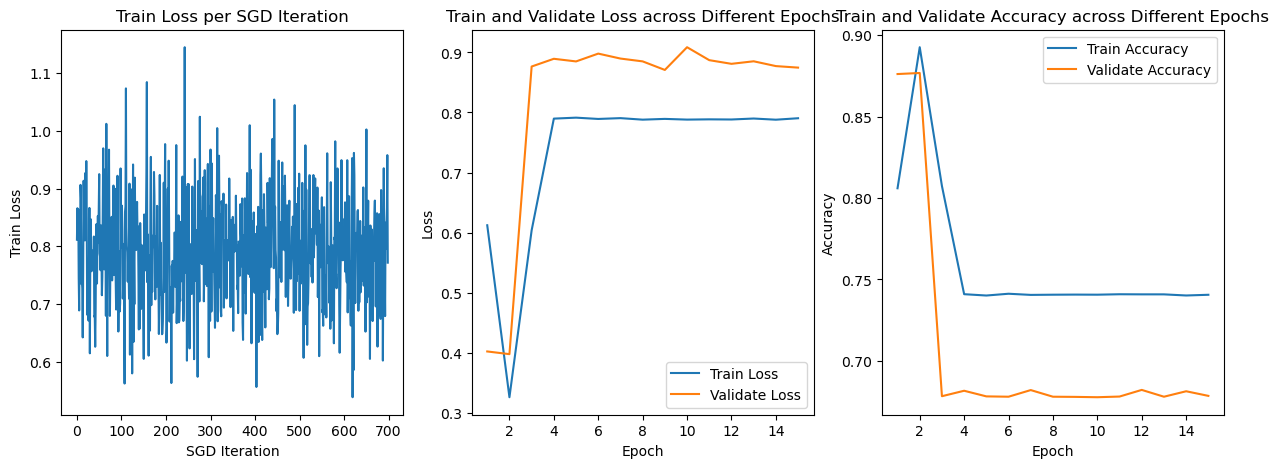

In [131]:
import matplotlib.pyplot as plt
import numpy as np

# Reshape losses and accuracies arrays to match the total number of train iterations
train_loss_per_iteration = np.array(batch_loss).reshape(-1)

# Create the plots
plt.figure(figsize=(15, 5))

# Plot 1: The train loss per SGD iteration
plt.subplot(1, 3, 1)
plt.plot(train_loss_per_iteration)
plt.xlabel('SGD Iteration')
plt.ylabel('Train Loss')
plt.title('Train Loss per SGD Iteration')

# Plot 2: The train and validate loss across different epochs
plt.subplot(1, 3, 2)
plt.plot(np.arange(1, N_epochs+1), losses, label='Train Loss')
plt.plot(np.arange(1, N_epochs+1), validate_losses, label='Validate Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validate Loss across Different Epochs')
plt.legend()

# Plot 3: The train and validate metric across different epochs
plt.subplot(1, 3, 3)
plt.plot(np.arange(1, N_epochs+1), accuracies, label='Train Accuracy')
plt.plot(np.arange(1, N_epochs+1), validate_accuracies, label='Validate Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validate Accuracy across Different Epochs')
plt.legend()

plt.tight_layout

In [132]:
# Load the best model
mybestmodel = myMultilayerPerceptron(x_train.shape[1],7)
mybestmodel.load_state_dict(torch.load("current_best_model"))

test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
test_batch_accuracy = []

for x_batch, y_batch in test_dataloader:
    prediction_score = mybestmodel(x_batch)
    prediction_label = torch.argmax(prediction_score.detach(),dim=1).numpy()
    test_batch_accuracy.append(np.sum(prediction_label == y_batch.numpy())/x_batch.shape[0])

test_accuracy = np.mean(np.array(test_batch_accuracy))

print(f"Test accuracy = {np.round(test_accuracy*100,2)}%")

Test accuracy = 86.95%


Shallow Model

Neural Network framework

In [133]:
import torch.nn as nn

class myMultilayerPerceptron(nn.Module):
    def __init__(self,input_dm,output_dm):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(input_dm,30),
            nn.Tanh(),
            nn.Linear(30,15),
            nn.Tanh(),
            nn.Linear(15,output_dm)
        )
    def forward(self,x):
        y = self.sequential(x)
        return y

In [134]:
mymodel = myMultilayerPerceptron(x_train.shape[1],7)
print(mymodel)

myMultilayerPerceptron(
  (sequential): Sequential(
    (0): Linear(in_features=35, out_features=30, bias=True)
    (1): Tanh()
    (2): Linear(in_features=30, out_features=15, bias=True)
    (3): Tanh()
    (4): Linear(in_features=15, out_features=7, bias=True)
  )
)


In [135]:
# hyperparameters
lr = 0.05 
batch_size = 64
N_epochs = 10

loss_fun = nn.CrossEntropyLoss()

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
validate_dataloader = DataLoader(validate_dataset, batch_size = batch_size, shuffle = True)

# Adam Optimizer
optimizer = torch.optim.Adam(mymodel.parameters(),lr = lr)

losses = []
accuracies = []

validate_losses = []
validate_accuracies = []

current_best_accuracy = 0.0

import numpy as np
for epoch in range(N_epochs):
    
    batch_loss = []
    batch_accuracy = []
    
    for x_batch,y_batch in train_dataloader:
        prediction_score = mymodel(x_batch)
        loss = loss_fun(prediction_score,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.detach().numpy())
        prediction_label = torch.argmax(prediction_score.detach(),dim=1).numpy()
        batch_accuracy.append(np.sum(prediction_label == y_batch.numpy())/x_batch.shape[0])
    
    validate_batch_loss = []
    validate_batch_accuracy = []
    
    for x_batch,y_batch in validate_dataloader:
        prediction_score = mymodel(x_batch)
        loss = loss_fun(prediction_score,y_batch)
        validate_batch_loss.append(loss.detach())
        prediction_label = torch.argmax(prediction_score.detach(),dim=1).numpy()
        validate_batch_accuracy.append(np.sum(prediction_label == y_batch.numpy())/x_batch.shape[0])
    
    losses.append(np.mean(np.array(batch_loss)))
    validate_losses.append(np.mean(np.array(validate_batch_loss)))
    
    accuracies.append(np.mean(np.array(batch_accuracy)))
    validate_accuracies.append(np.mean(np.array(validate_batch_accuracy)))
    
    print(f"Epoch={epoch},train_loss={losses[-1]},validate_loss={validate_losses[-1]}")
    print(f"Train_accuracy={np.round(accuracies[-1]*100,2)}%,validate_accuracy={np.round(validate_accuracies[-1]*100,2)}%")
    
    
    
    
    if validate_accuracies[-1]>current_best_accuracy:
        print("Current epoch is best so far, saving model...")
        torch.save(mymodel.state_dict(),'current_best_model')
        current_best_accuracy = validate_accuracies[-1]

Epoch=0,train_loss=0.1419348120689392,validate_loss=0.1641492247581482
Train_accuracy=94.88%,validate_accuracy=95.58%
Current epoch is best so far, saving model...
Epoch=1,train_loss=0.13145624101161957,validate_loss=0.14668823778629303
Train_accuracy=95.0%,validate_accuracy=94.97%
Epoch=2,train_loss=0.12162972241640091,validate_loss=0.161320760846138
Train_accuracy=95.37%,validate_accuracy=94.35%
Epoch=3,train_loss=0.13050733506679535,validate_loss=0.158644437789917
Train_accuracy=95.09%,validate_accuracy=94.65%
Epoch=4,train_loss=0.13148288428783417,validate_loss=0.15290473401546478
Train_accuracy=94.99%,validate_accuracy=95.12%
Epoch=5,train_loss=0.1224936917424202,validate_loss=0.16370399296283722
Train_accuracy=95.35%,validate_accuracy=94.43%
Epoch=6,train_loss=0.12530523538589478,validate_loss=0.15051129460334778
Train_accuracy=95.28%,validate_accuracy=95.33%
Epoch=7,train_loss=0.12626570463180542,validate_loss=0.1598827838897705
Train_accuracy=95.1%,validate_accuracy=95.03%
Epoc

Output plots

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

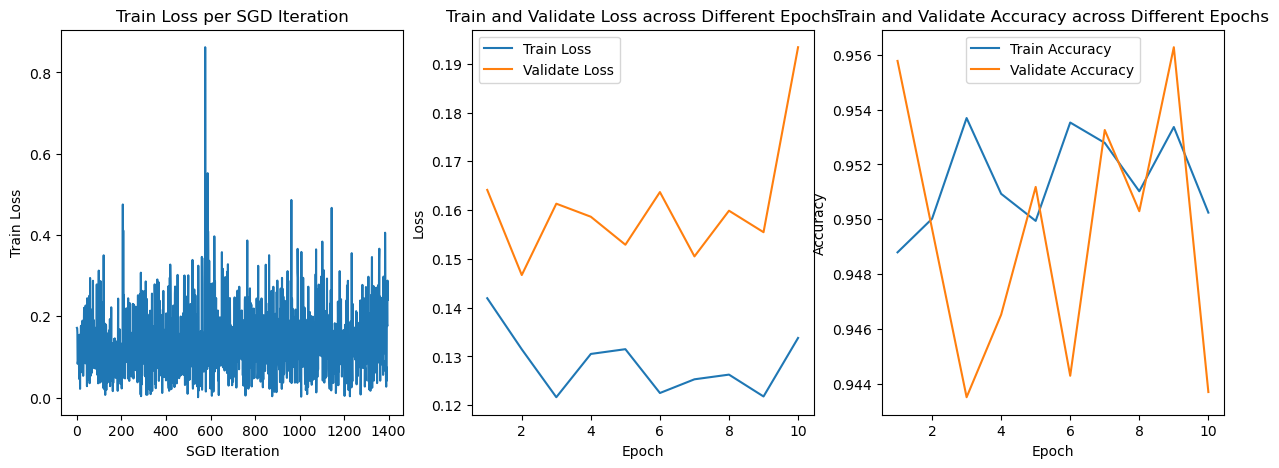

In [136]:
import matplotlib.pyplot as plt
import numpy as np

# Reshape losses and accuracies arrays to match the total number of train iterations
train_loss_per_iteration = np.array(batch_loss).reshape(-1)

# Create the plots
plt.figure(figsize=(15, 5))

# Plot 1: The train loss per SGD iteration
plt.subplot(1, 3, 1)
plt.plot(train_loss_per_iteration)
plt.xlabel('SGD Iteration')
plt.ylabel('Train Loss')
plt.title('Train Loss per SGD Iteration')

# Plot 2: The train and validate loss across different epochs
plt.subplot(1, 3, 2)
plt.plot(np.arange(1, N_epochs+1), losses, label='Train Loss')
plt.plot(np.arange(1, N_epochs+1), validate_losses, label='Validate Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validate Loss across Different Epochs')
plt.legend()

# Plot 3: The train and validate metric across different epochs
plt.subplot(1, 3, 3)
plt.plot(np.arange(1, N_epochs+1), accuracies, label='Train Accuracy')
plt.plot(np.arange(1, N_epochs+1), validate_accuracies, label='Validate Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validate Accuracy across Different Epochs')
plt.legend()

plt.tight_layout

Hypertuning it

In [137]:
# hyperparameters
lr = 0.001 
batch_size = 128
N_epochs = 50

loss_fun = nn.CrossEntropyLoss()

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
validate_dataloader = DataLoader(validate_dataset, batch_size = batch_size, shuffle = True)

# Adam Optimizer
optimizer = torch.optim.Adam(mymodel.parameters(),lr = lr)

losses = []
accuracies = []

validate_losses = []
validate_accuracies = []

current_best_accuracy = 0.0

import numpy as np
for epoch in range(N_epochs):
    
    batch_loss = []
    batch_accuracy = []
    
    for x_batch,y_batch in train_dataloader:
        prediction_score = mymodel(x_batch)
        loss = loss_fun(prediction_score,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.detach().numpy())
        prediction_label = torch.argmax(prediction_score.detach(),dim=1).numpy()
        batch_accuracy.append(np.sum(prediction_label == y_batch.numpy())/x_batch.shape[0])
    
    validate_batch_loss = []
    validate_batch_accuracy = []
    
    for x_batch,y_batch in validate_dataloader:
        prediction_score = mymodel(x_batch)
        loss = loss_fun(prediction_score,y_batch)
        validate_batch_loss.append(loss.detach())
        prediction_label = torch.argmax(prediction_score.detach(),dim=1).numpy()
        validate_batch_accuracy.append(np.sum(prediction_label == y_batch.numpy())/x_batch.shape[0])
    
    losses.append(np.mean(np.array(batch_loss)))
    validate_losses.append(np.mean(np.array(validate_batch_loss)))
    
    accuracies.append(np.mean(np.array(batch_accuracy)))
    validate_accuracies.append(np.mean(np.array(validate_batch_accuracy)))
    
    print(f"Epoch={epoch},train_loss={losses[-1]},validate_loss={validate_losses[-1]}")
    print(f"Train_accuracy={np.round(accuracies[-1]*100,2)}%,validate_accuracy={np.round(validate_accuracies[-1]*100,2)}%")
    
    
    
    
    if validate_accuracies[-1]>current_best_accuracy:
        print("Current epoch is best so far, saving model...")
        torch.save(mymodel.state_dict(),'current_best_model')
        current_best_accuracy = validate_accuracies[-1]

Epoch=0,train_loss=0.1245306208729744,validate_loss=0.1542425900697708
Train_accuracy=95.38%,validate_accuracy=95.1%
Current epoch is best so far, saving model...
Epoch=1,train_loss=0.11770651489496231,validate_loss=0.15358078479766846
Train_accuracy=95.46%,validate_accuracy=95.12%
Current epoch is best so far, saving model...
Epoch=2,train_loss=0.11714580655097961,validate_loss=0.15288476645946503
Train_accuracy=95.46%,validate_accuracy=95.11%
Epoch=3,train_loss=0.11672534793615341,validate_loss=0.15136821568012238
Train_accuracy=95.47%,validate_accuracy=95.11%
Epoch=4,train_loss=0.11650104075670242,validate_loss=0.15230758488178253
Train_accuracy=95.48%,validate_accuracy=95.11%
Epoch=5,train_loss=0.11637689918279648,validate_loss=0.15063975751399994
Train_accuracy=95.48%,validate_accuracy=95.1%
Epoch=6,train_loss=0.11610633134841919,validate_loss=0.14960314333438873
Train_accuracy=95.48%,validate_accuracy=95.15%
Current epoch is best so far, saving model...
Epoch=7,train_loss=0.11543

Output plots

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

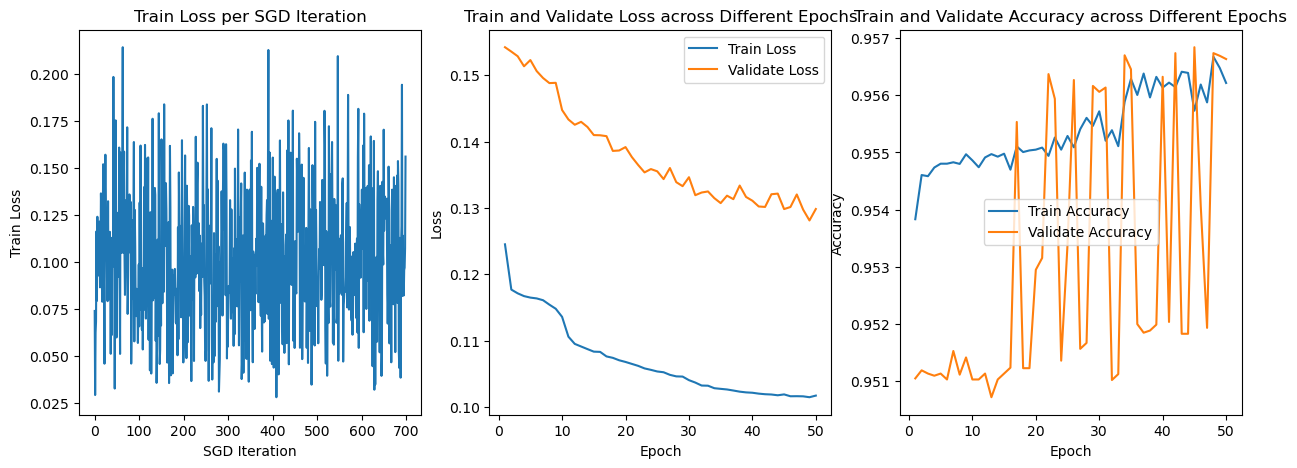

In [138]:
import matplotlib.pyplot as plt
import numpy as np

# Reshape losses and accuracies arrays to match the total number of train iterations
train_loss_per_iteration = np.array(batch_loss).reshape(-1)

# Create the plots
plt.figure(figsize=(15, 5))

# Plot 1: The train loss per SGD iteration
plt.subplot(1, 3, 1)
plt.plot(train_loss_per_iteration)
plt.xlabel('SGD Iteration')
plt.ylabel('Train Loss')
plt.title('Train Loss per SGD Iteration')

# Plot 2: The train and validate loss across different epochs
plt.subplot(1, 3, 2)
plt.plot(np.arange(1, N_epochs+1), losses, label='Train Loss')
plt.plot(np.arange(1, N_epochs+1), validate_losses, label='Validate Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validate Loss across Different Epochs')
plt.legend()

# Plot 3: The train and validate metric across different epochs
plt.subplot(1, 3, 3)
plt.plot(np.arange(1, N_epochs+1), accuracies, label='Train Accuracy')
plt.plot(np.arange(1, N_epochs+1), validate_accuracies, label='Validate Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validate Accuracy across Different Epochs')
plt.legend()

plt.tight_layout

Test Accuracy

In [139]:
# Load the best model
mybestmodel = myMultilayerPerceptron(x_train.shape[1],7)
mybestmodel.load_state_dict(torch.load("current_best_model"))

test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)
test_batch_accuracy = []

for x_batch, y_batch in test_dataloader:
    prediction_score = mybestmodel(x_batch)
    prediction_label = torch.argmax(prediction_score.detach(),dim=1).numpy()
    test_batch_accuracy.append(np.sum(prediction_label == y_batch.numpy())/x_batch.shape[0])

test_accuracy = np.mean(np.array(test_batch_accuracy))

print(f"Test accuracy = {np.round(test_accuracy*100,2)}%")

Test accuracy = 95.14%
